In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image
import os
import numpy as np

image_size = (128, 128)
data_dir = "/kaggle/input/satellite-image-classification/data"

X = []
y = []
class_names = sorted(os.listdir(data_dir))


for label, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_path):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).resize(image_size).convert('RGB')
            img_array = np.array(img) / 255.0  
            X.append(img_array)
            y.append(label)

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)


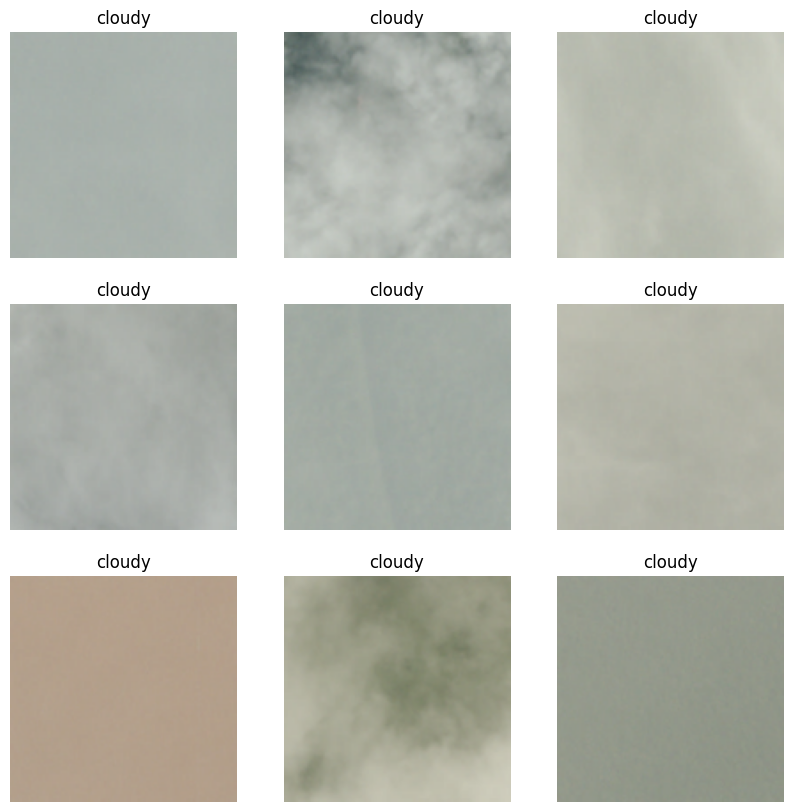

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis("off")

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt


2025-08-17 08:48:20.704953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755420500.900471      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755420500.958242      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
print("Dataset shape:", X.shape) 
print("Dataset shape:", y.shape) 
print(class_names) 


Dataset shape: (5631, 128, 128, 3)
Dataset shape: (5631,)
['cloudy', 'desert', 'green_area', 'water']


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755420609.337348      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755420609.338024      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint 


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/satimage_class.h5',  # <-- save to working directory
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint]
)


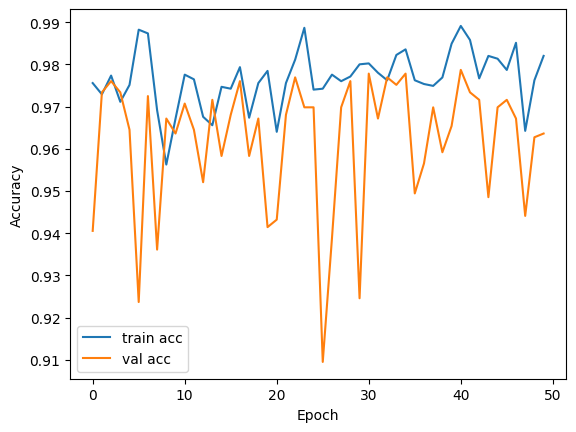

In [22]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


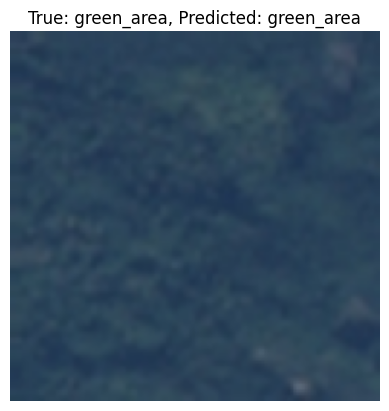

In [23]:
import matplotlib.pyplot as plt
import numpy as np

index = 300  # pick any image index
img = X_val[index]
true_label = y_val[index]

# CNN expects batch dimension → (1, 128, 128, 3)
img_batch = np.expand_dims(img, axis=0)

# Predict
predictions = model.predict(img_batch)
predicted_class = np.argmax(predictions[0])

# Get class name (if you have class_names list)
true_class_name = class_names[true_label]
predicted_class_name = class_names[predicted_class]

plt.imshow(img)
plt.title(f"True: {true_class_name}, Predicted: {predicted_class_name}")
plt.axis("off")
plt.show()
